In [1]:
# !pip install pytube opencv-python torch

In [1]:
import cv2
import os
from pytube import YouTube

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from scipy.io import wavfile

import torch

In [6]:
sr, audio = wavfile.read('outputs/car2cam/audio.wav')
audio = audio.T[0]
ss = sr-1000

In [15]:
duration = audio.size//ss

In [26]:
left = np.linspace(1, 0, ss)
left = np.tile(left, duration)

C:\Users\statix\AppData\Local\Temp\ipykernel_14876\3431937133.py:1: RuntimeWarning: invalid value encountered in divide
  audio = audio/left


(423000,)

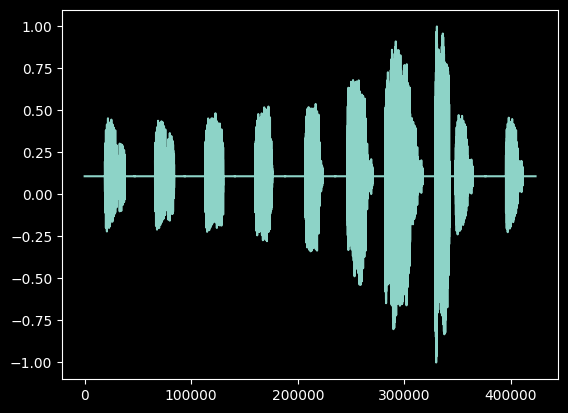

In [32]:
audio = audio/left
plt.plot(audio)
audio.shape

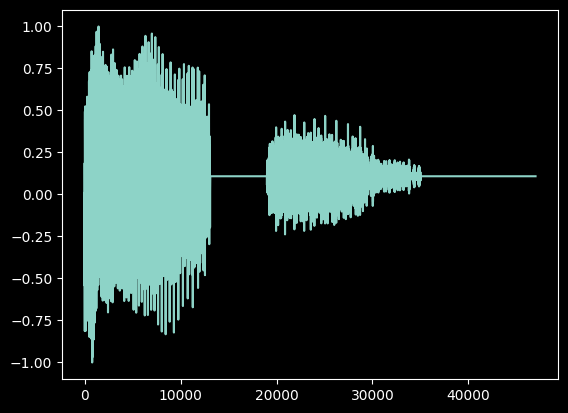

In [38]:
n = 7
signal = audio[n*ss:(n+1)*ss]
plt.plot(signal)

In [24]:
from util import get_dmap, get_object_bboxes

Using cache found in C:\Users\statix/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\statix/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\statix/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-22 Python-3.11.5 torch-2.2.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [38]:
fps = 15
for n in range(8):
    vid = cv2.VideoCapture('videos/car2cam.mp4')

    frame_num = 0
    while frame_num <= n*fps:
        ret, img = vid.read()
        frame_num += 1

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[:, :1250]
    signal = audio[n*ss:(n+1)*ss]

    dmap = get_dmap(img)
    df = get_object_bboxes(img)
    obj_filtered = np.zeros_like(dmap)
    for objs in df[df.confidence>0.6].iterrows():
        xmin, ymin, xmax, ymax = objs[1][:4]
        obj_filtered[ymin:ymax, xmin:xmax] = dmap[ymin:ymax, xmin:xmax]

    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    for ax in axs:
        ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[1].set_title("Depth Map")
    axs[1].imshow(cv2.resize(obj_filtered, img.shape[1::-1]))

    ax = axs[2]
    ax.set_title("Signal")
    ax.plot(signal)
    ax.set_ylim(-1.1, 1.1)

    fig.savefig(f'outputs/car2cam/image_{n:0>3}.jpg')    


In [3]:
# link = "https://www.youtube.com/watch?v=2jyaF7umMyQ"
# video = YouTube(link).streams.filter(only_video=True)[0]
# video.download('videos', filename='badminton_full.mp4')

In [4]:
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
transform = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\statix/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\statix/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\statix/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-22 Python-3.11.5 torch-2.2.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [26]:
matplotlib.use('TkAgg')

C:\Users\statix\AppData\Local\Temp\ipykernel_2316\1800837942.py:1: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('TkAgg')


In [28]:
vid = cv2.VideoCapture('videos/car2cam.mp4')

GET_Nth_FRAME = 0

frame_num = 0
while frame_num < GET_Nth_FRAME+1:
    ret, img = vid.read()
    frame_num += 1
    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[:, :1250]

plt.imshow(img)

: 

In [6]:
CROP = {
    'xmin': None,
    'xmax': 1250,
    'ymin': None,
    'ymax': None
}

In [7]:
with torch.no_grad():
    preds = midas(transform(img))
    preds = torch.nn.functional.interpolate(
        preds.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    df = yolo(img).pandas().xyxy[0]

dmap = preds.numpy().copy()
dmap = dmap - dmap.min()
dmap = dmap/dmap.max()
df

,xmin,ymin,xmax,ymax,confidence,class,name
0,868.707581,344.665070,1008.255798,445.529663,0.846901,2,car
1,813.014771,361.218964,886.822815,411.186981,0.801807,2,car
2,775.754028,348.490326,819.578857,429.130646,0.758904,2,car
3,523.900879,243.167480,781.693726,449.666504,0.646505,7,truck


In [8]:
for col in ['xmin', 'ymin', 'xmax', 'ymax']:
    df[col] = df[col].astype(int)

df

,xmin,ymin,xmax,ymax,confidence,class,name
0,868,344,1008,445,0.846901,2,car
1,813,361,886,411,0.801807,2,car
2,775,348,819,429,0.758904,2,car
3,523,243,781,449,0.646505,7,truck


In [9]:
CONF_THRES = 0.2
obj_filtered = np.zeros_like(dmap)
for objs in df[df.confidence>CONF_THRES].iterrows():
    xmin, ymin, xmax, ymax = objs[1][:4]
    obj_filtered[ymin:ymax, xmin:xmax] = dmap[ymin:ymax, xmin:xmax]

obj_filtered = cv2.resize(obj_filtered, (200,150))

In [10]:
obj_filtered.shape

(150, 200)

In [11]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
gray.shape

(1080, 1250)

In [12]:
sr = 48000

#creating all the waves
time_x=np.arange(0, 1, 1.0/sr)
freqs = np.exp(np.linspace(np.log(20_000), np.log(30), 150))

tones = np.sin(2.0 * np.pi * freqs.reshape(-1, 1) * time_x)

signal = np.repeat(obj_filtered, tones.shape[1]/obj_filtered.shape[1], axis=1) * tones

signal = signal.sum(axis=0)[1000:]
wav_range = [-1,1]
signal -= signal.min()
signal /= signal.max() / (wav_range[1] - wav_range[0])
signal += wav_range[0]

left = np.linspace(1, 0, signal.size)
right = np.linspace(0, 1, signal.size)
tone_y_stereo=np.vstack(( left*signal, right*signal))
tone_y_stereo=tone_y_stereo.transpose()
wavfile.write('testAudio.wav', sr, tone_y_stereo)

(150, 200)

In [43]:
img.shape[::-1]

(3, 1250, 1080)

In [58]:
matplotlib.use('TkAgg')
fig, axs = plt.subplots(1, 3, figsize=(20,5))

for ax in axs:
    ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].imshow(img)
axs[1].imshow(cv2.resize(obj_filtered, img.shape[1::-1]))
axs[2].plot(signal)

plt.show()